# Extract AVIRIS CH4 Plume Estimates at VISTA Points

## ER 131 Project | Group 4
**Author: ** ['Marshall Worsham'] <br>
**Date: ** 11-24-2020

## Libraries

In [8]:
#!pip3 install rioxarray
#!pip3 install rasterstats
#!pip3 install earthpy

In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import glob
import time
import descartes
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import rasterstats as rs
from shapely.geometry import box

# rasterio modules
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling

# rioxarray modules
import rioxarray as rx

# earthpy modules
import earthpy as et
import earthpy.plot as ep

## Set working directories

In [10]:
datadir = os.sep.join(['/Volumes', 'Brain', 'GIS', 'ER131', 'Project', 'Data'])
outdir = os.sep.join(['/Volumes', 'Brain', 'GIS', 'ER131', 'Project', 'Output'])

## Get a sample AVIRIS flightpath with CH4 plume

In [11]:
# Load & plot the data
aviris = os.sep.join([datadir, 'CH4_Plume_AVIRIS-NG', 'data'])
aviris_test = os.sep.join([aviris, 'ang20171016t175805_cmf_pub_ch4.tif'])

with rio.open(aviris_test) as aviris_src:
    # Masked = True sets no data values to np.nan if they are in the metadata
    ch4_data = aviris_src.read(1, masked=True)
    ch4_meta = aviris_src.profile

In [12]:
# what is the flightpath's CRS?
aviris_src.crs

CRS.from_epsg(32611)

In [278]:
# what are the max/min x and y of the flightpath?
print(aviris_src.bounds)

BoundingBox(left=356877.042825, bottom=3795656.3763534767, right=363866.02280326944, top=3802824.3460612334)


PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


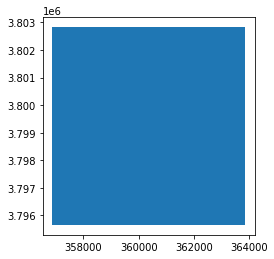

In [280]:
# create a polygon geometry based on the flightpath bounding box
bounds = avi.bounds
bounds_polygon = [box(bounds[0], bounds[1], bounds[2], bounds[3])]

# make it a geodataframe
df = pd.DataFrame(range(0))
flight_bnd = gpd.GeoDataFrame(df, geometry = bounds_polygon, crs = avi.crs)
flight_bnd.plot()
print(flight_bnd.crs);

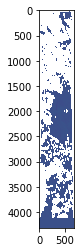

In [281]:
with rio.open(aviris_test) as aviris_src:
    src_valid = aviris_src.read(1, masked = True)
    src_meta = aviris_src.profile
    rio.plot.show(src_valid, with_bounds = False, transform = aviris_src.transform);

In [144]:
print(src_meta)
print(src_valid.shape)
print(src_valid[0].shape)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 690, 'height': 4316, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(1.4386796006773024, 1.3893167409179945, 356877.042825,
       1.3893167409179945, -1.4386796006773024, 3801865.71751), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
(4316, 690)
(690,)


In [145]:
type(src_valid)

numpy.ndarray

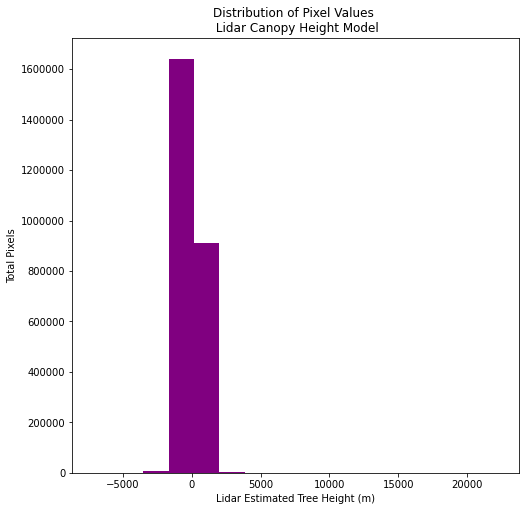

In [134]:
ax=ep.hist(src_valid,
        bins=16,
        figsize=(8,8),
        colors="purple",
        xlabel="Lidar Estimated Tree Height (m)",
        ylabel="Total Pixels",
        title="Distribution of Pixel Values \n Lidar Canopy Height Model")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                     style='plain')

In [135]:
print(np.nanmean(src_valid))
print(np.nanmin(src_valid))
print(np.nanmax(src_valid))

-0.019631417870022594
-7213.426157791784
22266.50510115642


## Rioxarray
For a while I was just working with rasterio, so thought I'd try rioxarray to see if retransforming, etc. could help. But there doesn't seem to be a simple way to get zonal stats out of a rioxarray.

In [101]:
xarr = rx.open_rasterio(aviris_test, masked = True)
xarr

<xarray.DataArray (band: 1, y: 4316, x: 690)>
[2978040 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
Dimensions without coordinates: y, x
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     CH4 Absorption (ppm x m)
    grid_mapping:  spatial_ref

In [136]:
print(xarr.rio.crs)
print(xarr.rio.bounds())
print(xarr.shape)

EPSG:32611
(356877.042825, 3795656.3763534767, 357869.7317494674, 3801865.71751)
(1, 4316, 690)


In [102]:
xarr_valid = xarr.squeeze()

In [113]:
xarr_valid.rio.transform()

Affine(1.4386796006773024, 0.0, 356877.042825,
       0.0, -1.4386796006773024, 3801865.71751)

In [104]:
print(xarr_valid.max())
print(xarr_valid.min())

<xarray.DataArray ()>
array(22266.50510116)
Coordinates:
    band         int64 1
    spatial_ref  int64 0
<xarray.DataArray ()>
array(-9999.)
Coordinates:
    band         int64 1
    spatial_ref  int64 0


In [128]:
xarr[:2].plot()

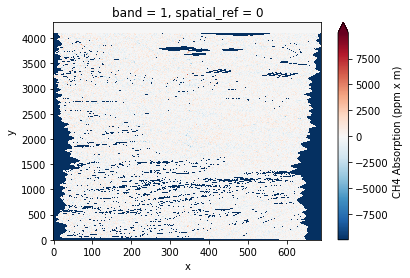

In [105]:
xarr_valid.plot.imshow(robust=True);

## Pull in the emitter points

In [38]:
vistadir = os.sep.join([outdir, 'CH4_Emitters']) # specify the directory
vista_gjson = os.sep.join([vistadir, 'CH4_Emitters_All.geojson']) # get the emitters
vista = gpd.read_file(vista_gjson, low_memory = False) # import

In [39]:
vista_utm = vista.geometry.to_crs(aviris_src.crs) # match flightpath crs
vista_utm.crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
vista.geometry = vista_utm
vista['Centroid'] = vista.centroid

In [41]:
vista.head()

,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,County,geometry,Centroid
0,37.72799,-120.89865,4B Biological Treatment of Solid Waste,"3D Ag, LLC",Composting Sites,CMP000001,2019-08-20,CA,Oakdale,CalRecycle,None,"POLYGON ((156381.787 4182805.578, 156383.517 4...",POINT (156381.369 4182795.576)
1,33.70999,-117.32864,4B Biological Treatment of Solid Waste,"A. Lua Recycling, Inc.",Composting Sites,CMP000002,2019-08-20,CA,Lake Elsinore,CalRecycle,None,"POLYGON ((469548.028 3730059.468, 469549.763 3...",POINT (469547.996 3730049.472)
2,38.01667,-122.13333,4B Biological Treatment of Solid Waste,Acme Composting Compost Facility,Composting Sites,CMP000003,2019-08-20,CA,Martinez,CalRecycle,None,"POLYGON ((49263.412 4220129.222, 49265.141 422...",POINT (49262.858 4220119.216)
3,34.03281,-118.35424,4B Biological Treatment of Solid Waste,Adams Garden Supply,Composting Sites,CMP000004,2019-08-20,CA,Los Angeles (City),CalRecycle,None,"POLYGON ((374982.722 3766630.867, 374984.456 3...",POINT (374982.590 3766620.869)
4,34.44517,-117.29007,4B Biological Treatment of Solid Waste,Advance Disposal Center for the Environm,Composting Sites,CMP000005,2019-08-20,CA,Hesperia,CalRecycle,None,"POLYGON ((473353.198 3811565.486, 473354.933 3...",POINT (473353.169 3811555.490)


In [209]:
# turn it into a separate gpdf with geometry as centroid of polygon in original
emitpts = gpd.GeoDataFrame(vista, geometry=gpd.points_from_xy(vista['Centroid'].x, vista['Centroid'].y, crs = aviris_src.crs)).drop(columns = 'Centroid')

In [210]:
emitpts.crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [211]:
emitpts_samp = emitpts.groupby('Vista_SType').sample(frac = 0.01, random_state = 42)
print(len(emitpts_samp))

2344


## Pull in counties for mapping

In [391]:
counties = gpd.read_file(os.sep.join([datadir, 'CA_Counties', 'CA_Counties_TIGER2016.shp']))
counties_utm = counties.to_crs(epsg=32611);

In [392]:
counties_utm.crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 120°W to 114°W - by country
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Find points within the flightpath's boundary

In [387]:
pip = emitpts.within(flight_bnd.loc[0, 'geometry'])

In [332]:
pip = emitpts.loc[pip]

In [333]:
len(pip)

304

In [334]:
pip.head()

,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,County,geometry
135,34.341250,-118.527040,4B Biological Treatment of Solid Waste,"Foothill Soils, Inc.",Composting Sites,CMP000136,2019-08-20,CA,Newhall (In Santa Clarita),CalRecycle,None,POINT (359541.480 3801050.191)
2283,34.327254,-118.515930,4A1 Managed Waste Disposal Sites,Sunshine Canyon City/County Landfill,Landfill,LNF000615,2019-11-10,None,Los Angeles,CalRecycle,None,POINT (360552.294 3799471.824)
4226,34.308033,-118.551871,1B2 Oil and Natural Gas,Limekiln Canyon,Natural Gas Station,COM000256,2019-08-20,CA,None,CEC,Los Angeles,POINT (357199.932 3797399.008)
7448,34.316341,-118.508570,1B2 Oil and Natural Gas,"DCOR, LLC",Oil and Gas Facility Boundary,FAB001329,8/20/2019,CA,None,CEC,None,POINT (361199.472 3798262.449)
7604,34.306043,-118.539216,1B2 Oil and Natural Gas,Southern California Gas Company,Oil and Gas Facility Boundary,FAB002748,8/20/2019,CA,None,CEC,None,POINT (358362.272 3797162.722)


## Make a buffer around points to extract zonal stats

In [363]:
emitbuff = pip.copy()
emitbuff["geometry"] = pip.geometry.buffer(100)
emitbuff.head()

,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_SType,Vista_ID,Vista_Date,State,City,Source,County,geometry
135,34.341250,-118.527040,4B Biological Treatment of Solid Waste,"Foothill Soils, Inc.",Composting Sites,CMP000136,2019-08-20,CA,Newhall (In Santa Clarita),CalRecycle,None,"POLYGON ((359641.480 3801050.191, 359640.998 3..."
2283,34.327254,-118.515930,4A1 Managed Waste Disposal Sites,Sunshine Canyon City/County Landfill,Landfill,LNF000615,2019-11-10,None,Los Angeles,CalRecycle,None,"POLYGON ((360652.294 3799471.824, 360651.813 3..."
4226,34.308033,-118.551871,1B2 Oil and Natural Gas,Limekiln Canyon,Natural Gas Station,COM000256,2019-08-20,CA,None,CEC,Los Angeles,"POLYGON ((357299.932 3797399.008, 357299.450 3..."
7448,34.316341,-118.508570,1B2 Oil and Natural Gas,"DCOR, LLC",Oil and Gas Facility Boundary,FAB001329,8/20/2019,CA,None,CEC,None,"POLYGON ((361299.472 3798262.449, 361298.991 3..."
7604,34.306043,-118.539216,1B2 Oil and Natural Gas,Southern California Gas Company,Oil and Gas Facility Boundary,FAB002748,8/20/2019,CA,None,CEC,None,"POLYGON ((358462.272 3797162.722, 358461.791 3..."


## Plot counties, flightpath, and points

In [397]:
### Plot from rio

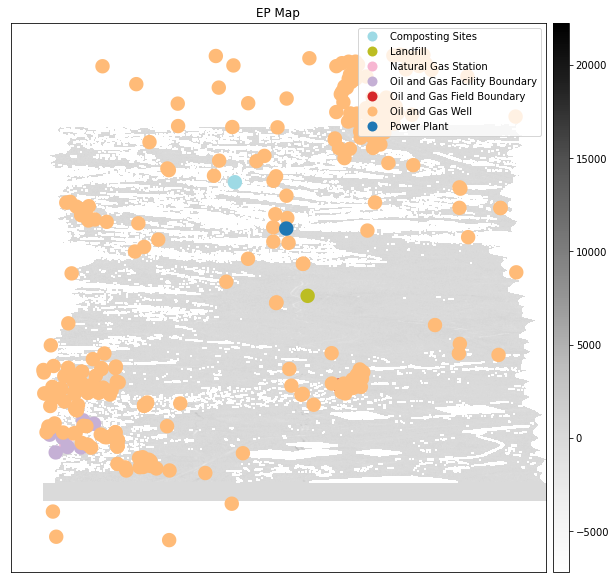

In [401]:
fig, ax = plt.subplots(figsize=(10, 15))
#counties_utm.plot(ax=ax, color = 'dimgrey', edgecolor='white', alpha = 0.8);
ep.plot_bands(src_valid,
              extent=plotting_extent(src_valid, transform = src_meta['transform']), # Set spatial extent 
              cmap='Greys',
              title="EP Map",
              #scale=False,
              ax=ax);
emitbuff.plot(ax=ax,
              column = 'Vista_SType',
              marker='s',
              markersize=45,
              cmap='tab20_r',
              legend = True);

In [398]:
### Plot from rioxarray

<AxesSubplot:title={'center':'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

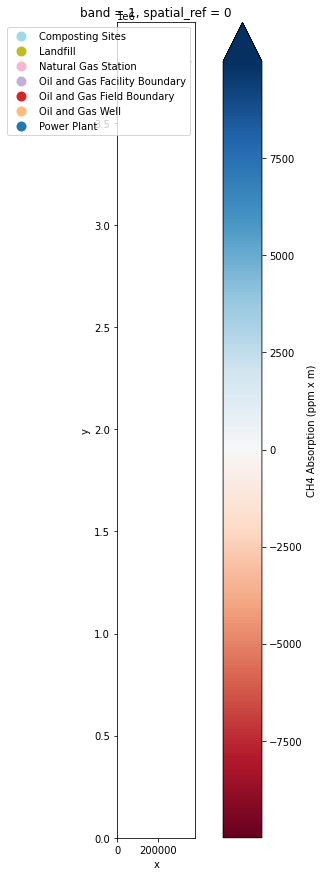

In [404]:
fig, ax = plt.subplots(figsize=(10,15))
xarr_valid.plot.imshow(ax=ax, robust = True, cmap = 'RdBu', extent = plotting_extent(xarr_valid, xarr_valid.rio.transform()))
emitbuff.plot(ax=ax, column = 'Vista_SType', edgecolor = 'whitesmoke', cmap = 'tab20_r', legend = True)
#counties_utm.plot(ax=ax, color = 'dimgrey', edgecolor='white', alpha = 0.8)
#flight_bnd.plot(ax=ax, color = 'red')

## Zonal statistics on buffered points

In [405]:
src_valid_shp = emitbuff.to_file('src_valid.shp')

In [406]:
vector = '/Users/hmworsham/Desktop/ER131/Project/Code/src_valid.shp'

In [410]:
# time it
start = time.time()

# Extract zonal stats
zstats = rs.zonal_stats(
    vector,
    aviris_test, 
    nodata = -9999.0,
    affine=src_meta['transform'],
    geojson_out = True,
    copy_properties = True,
    stats = ['count', 'mean'],
    all_touching = True,
    )

print(type(zstats))

zstats_gpdf = gpd.GeoDataFrame.from_features(zstats)

# end time
end = time.time()
print(f'Runtime: {end - start} seconds')

<class 'list'>
Runtime: 1.4405319690704346 seconds


In [412]:
zstats_gpdf.head()

,geometry,Latitude,Longitude,Vista_IPCC,Vista_Name,Vista_STyp,Vista_ID,Vista_Date,State,City,Source,County,count,mean
0,"POLYGON ((359641.480 3801050.191, 359640.998 3...",34.341250,-118.527040,4B Biological Treatment of Solid Waste,"Foothill Soils, Inc.",Composting Sites,CMP000136,2019-08-20,CA,Newhall (In Santa Clarita),CalRecycle,None,0,None
1,"POLYGON ((360652.294 3799471.824, 360651.813 3...",34.327254,-118.515930,4A1 Managed Waste Disposal Sites,Sunshine Canyon City/County Landfill,Landfill,LNF000615,2019-11-10,None,Los Angeles,CalRecycle,None,0,None
2,"POLYGON ((357299.932 3797399.008, 357299.450 3...",34.308033,-118.551871,1B2 Oil and Natural Gas,Limekiln Canyon,Natural Gas Station,COM000256,2019-08-20,CA,None,CEC,Los Angeles,0,None
3,"POLYGON ((361299.472 3798262.449, 361298.991 3...",34.316341,-118.508570,1B2 Oil and Natural Gas,"DCOR, LLC",Oil and Gas Facility Boundary,FAB001329,8/20/2019,CA,None,CEC,None,0,None
4,"POLYGON ((358462.272 3797162.722, 358461.791 3...",34.306043,-118.539216,1B2 Oil and Natural Gas,Southern California Gas Company,Oil and Gas Facility Boundary,FAB002748,8/20/2019,CA,None,CEC,None,0,None


In [254]:
reproj = xarr.rio.reproject('epsg:32611')

In [200]:
reproj = reproj.squeeze()